In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [30]:
# Parameters
Lx, Ly = 100 * 10**3, 100 * 10**3
Total_time = 1000.0
g = 9.81
viscosity = 10.0
Nx, Ny = 100, 100
dx, dy = Lx / (Nx + 2), Ly / (Ny + 2)
x_coord = np.linspace(0, Lx, Nx + 2)
y_coord = np.linspace(0, Ly, Ny + 2)
h0 = 4000
delta_t = 0.1

In [31]:
[1,2,3] + [4,5,6]

[1, 2, 3, 4, 5, 6]

In [32]:
# Initial Conditions
exp0 = 1.0
wave_width = 10000.0
x_center, y_center =  Lx / 2, Ly / 2
exp = exp0 * np.exp(-((x_coord[:, None] - x_center)**2 + (y_coord[None, :] - y_center)**2) / (2 * wave_width**2))

h_initial = h0 + exp
u_initial = np.zeros((Nx + 2, Ny + 2))
v_initial = np.zeros((Nx + 2, Ny + 2))

#List of points in boundary (in this case its a channel)
POINTS_BDARY = [[i,j] for i in range (Nx//4, Nx//3) for j in range(Ny//4, Ny//2)] + [[i,j] for i in range (2*Nx//3, 3*Nx//4) for j in range(Ny//4, Ny//2)]

# Boundary conditions 2D reflecting walls
u_boundary = 0
v_boundary = 0

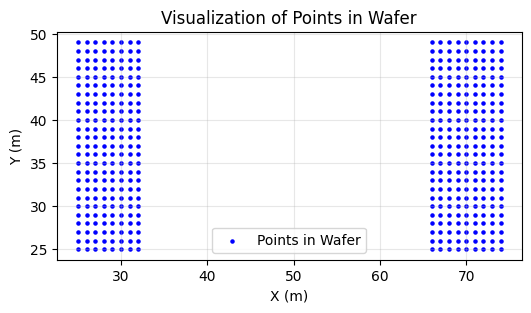

In [33]:
# Extract x and y coordinates for plotting
x_coords, y_coords = zip(*POINTS_BDARY)

# Plotting the points
plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, color='blue', s=5, label="Points in Wafer")
plt.gca().set_aspect('equal', adjustable='box')  # Ensure equal aspect ratio for proper circular shape
plt.title("Visualization of Points in Wafer")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [37]:
def pde_system_2D_bd(t, y):
    h = y[: (Nx + 2) * (Ny + 2)].reshape((Nx + 2, Ny + 2))
    u = y[(Nx + 2) * (Ny + 2) : 2 * (Nx + 2) * (Ny + 2)].reshape((Nx + 2, Ny + 2))
    v = y[2 * (Nx + 2) * (Ny + 2) :].reshape((Nx + 2, Ny + 2))

    # Compute derivatives
    dh_dx = np.zeros_like(h)
    dh_dy = np.zeros_like(h)
    du_dx = np.zeros_like(u)
    du_dy = np.zeros_like(u)
    dv_dx = np.zeros_like(v)
    dv_dy = np.zeros_like(v)

    # Finite differences for interior points
    dh_dx[1:-1, 1:-1] = (h[2:, 1:-1] - h[:-2, 1:-1]) / (2 * dx)
    dh_dy[1:-1, 1:-1] = (h[1:-1, 2:] - h[1:-1, :-2]) / (2 * dy)
    du_dx[1:-1, 1:-1] = (u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dx)
    du_dy[1:-1, 1:-1] = (u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dy)
    dv_dx[1:-1, 1:-1] = (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dx)
    dv_dy[1:-1, 1:-1] = (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dy)

    dh_dt = np.zeros_like(h)
    du_dt = np.zeros_like(u)
    dv_dt = np.zeros_like(v)

    dh_dt[1:-1, 1:-1] = -h[1:-1, 1:-1] * (du_dx[1:-1, 1:-1] + dv_dy[1:-1, 1:-1]) - u[1:-1, 1:-1] * dh_dx[1:-1, 1:-1] - v[1:-1, 1:-1] * dh_dy[1:-1, 1:-1]
    du_dt[1:-1, 1:-1] = -u[1:-1, 1:-1] * du_dx[1:-1, 1:-1] - u[1:-1, 1:-1] * dv_dy[1:-1, 1:-1]- v[1:-1, 1:-1] * du_dy[1:-1, 1:-1] - g * dh_dx[1:-1, 1:-1] + viscosity * ((u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2 + (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2)
    dv_dt[1:-1, 1:-1] = -u[1:-1, 1:-1] * dv_dx[1:-1, 1:-1] - v[1:-1, 1:-1] * du_dx[1:-1, 1:-1] - v[1:-1, 1:-1] * dv_dy[1:-1, 1:-1] - g * dh_dy[1:-1, 1:-1] + viscosity * ((v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[:-2, 1:-1]) / dx**2 + (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, :-2]) / dy**2)

    for point in POINTS_BDARY:
        du_dt[point[0], point[1]] = 0
        dv_dt[point[0], point[1]] = 0
    return np.concatenate((dh_dt.ravel(), du_dt.ravel(), dv_dt.ravel()))

In [38]:
def pde_system_2D(t, y):
    h = y[: (Nx + 2) * (Ny + 2)].reshape((Nx + 2, Ny + 2))
    u = y[(Nx + 2) * (Ny + 2) : 2 * (Nx + 2) * (Ny + 2)].reshape((Nx + 2, Ny + 2))
    v = y[2 * (Nx + 2) * (Ny + 2) :].reshape((Nx + 2, Ny + 2))

    # Compute derivatives
    dh_dx = np.zeros_like(h)
    dh_dy = np.zeros_like(h)
    du_dx = np.zeros_like(u)
    du_dy = np.zeros_like(u)
    dv_dx = np.zeros_like(v)
    dv_dy = np.zeros_like(v)

    # Finite differences for interior points
    dh_dx[1:-1, 1:-1] = (h[2:, 1:-1] - h[:-2, 1:-1]) / (2 * dx)
    dh_dy[1:-1, 1:-1] = (h[1:-1, 2:] - h[1:-1, :-2]) / (2 * dy)
    du_dx[1:-1, 1:-1] = (u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dx)
    du_dy[1:-1, 1:-1] = (u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dy)
    dv_dx[1:-1, 1:-1] = (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dx)
    dv_dy[1:-1, 1:-1] = (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dy)

    dh_dt = np.zeros_like(h)
    du_dt = np.zeros_like(u)
    dv_dt = np.zeros_like(v)

    dh_dt[1:-1, 1:-1] = -h[1:-1, 1:-1] * (du_dx[1:-1, 1:-1] + dv_dy[1:-1, 1:-1]) - u[1:-1, 1:-1] * dh_dx[1:-1, 1:-1] - v[1:-1, 1:-1] * dh_dy[1:-1, 1:-1]
    du_dt[1:-1, 1:-1] = -u[1:-1, 1:-1] * du_dx[1:-1, 1:-1] - v[1:-1, 1:-1] * du_dy[1:-1, 1:-1] - g * dh_dx[1:-1, 1:-1] + viscosity * ((u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2 + (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2)
    dv_dt[1:-1, 1:-1] = -u[1:-1, 1:-1] * dv_dx[1:-1, 1:-1] - v[1:-1, 1:-1] * dv_dy[1:-1, 1:-1] - g * dh_dy[1:-1, 1:-1] + viscosity * ((v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[:-2, 1:-1]) / dx**2 + (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, :-2]) / dy**2)

    return np.concatenate((dh_dt.ravel(), du_dt.ravel(), dv_dt.ravel()))

In [39]:
a = np.array([1,2,3,4])
b= np.array([1,2,5,1])
c = abs(b - np.sqrt(g*a))
c

array([2.13209195, 2.42944692, 0.4249424 , 5.26418391])

In [40]:
a[:]=1
a

array([1, 1, 1, 1])

In [41]:
def compute_time_step_1D(y):
    safety_factor = 0.7
    h = y[:Nx + 2]
    u = y[Nx + 2:]
    if len(u) != len(h):
        u = np.concatenate(([u_boundary], u, [u_boundary]))
    evals_1 = abs(u - np.sqrt(g*h))
    evals_2 = abs(u + np.sqrt(g*h))
    max_eval = max(max(evals_1), max(evals_2))
    time_step = safety_factor * dx /max_eval
    return time_step

In [42]:
def rungeKutta_2D(y0, tspan, delta_t, ode):
    t0, tend = tspan
    t = [t0]
    y = [y0]

    # Determine the number of time steps
    num_steps = int((tend - t0) / delta_t)
    h_data = []

    for step in range(num_steps):

        k1 = delta_t * ode(t0, y[-1])
        k2 = delta_t * ode(t0 + 0.5 * delta_t, y[-1] + 0.5 * k1)
        k3 = delta_t * ode(t0 + 0.5 * delta_t, y[-1] + 0.5 * k2)
        k4 = delta_t * ode(t0 + delta_t, y[-1] + k3)

        y_next = y[-1] + (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        # Apply boundary conditions
        h_next = y_next[: (Nx + 2) * (Ny + 2)].reshape((Nx + 2, Ny + 2))
        u_next = y_next[(Nx + 2) * (Ny + 2) : 2 * (Nx + 2) * (Ny + 2)].reshape((Nx + 2, Ny + 2))
        v_next = y_next[2 * (Nx + 2) * (Ny + 2) :].reshape((Nx + 2, Ny + 2))

        # Boundarie Conditions for reflecting walls
        u_next[:, 0] = u_boundary
        u_next[:, -1] = u_boundary
        v_next[:, 0] = v_boundary
        v_next[:, -1] = v_boundary
        h_next[:, 0] = h_next[:, 1]
        h_next[:, -1] = h_next[:, -2]
        u_next[0, :] = u_boundary
        u_next[-1, :] = u_boundary
        v_next[0, :] = v_boundary
        v_next[-1, :] = v_boundary
        h_next[0, :] = h_next[1, :]
        h_next[-1, :] = h_next[-2, :]

        

        # Flatten y_next back into a vector
        y_next = np.concatenate((h_next.ravel(), u_next.ravel(), v_next.ravel()))

        t0 += delta_t
        t.append(t0)
        y.append(y_next)

        if step % 10 == 0:
            h_data.append(h_next.copy())

    return t, y, np.array(h_data)

In [43]:
# Solve system
y0 = np.concatenate((h_initial.ravel(), u_initial.ravel(), v_initial.ravel()))
t_values, solution_values, h_data = rungeKutta_2D(y0, (0.0, Total_time), delta_t, pde_system_2D_bd)

MovieWriter ffmpeg unavailable; using Pillow instead.


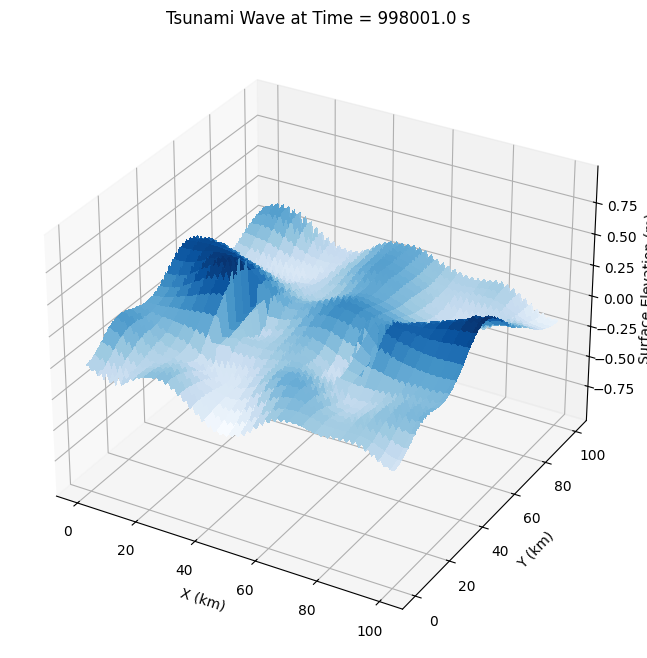

In [44]:
# Animation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x_mesh, y_mesh = np.meshgrid(x_coord / 1000.0, y_coord / 1000.0)
max_amplitude = np.max(np.abs(h_data - h0))

def animate(i):
    ax.clear()
    data = h_data[i].T - h0
    surf = ax.plot_surface(x_mesh, y_mesh, data, cmap="Blues", rstride=4, cstride=4, linewidth=0, antialiased=False)
    ax.set_zlim(-max_amplitude, max_amplitude)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Surface Elevation (m)')
    ax.set_title(f"Tsunami Wave at Time = {i * t_values[i] * 10:.1f} s")
    return surf,

ani = animation.FuncAnimation(fig, animate, frames=len(h_data), interval=20, blit=True)
ani.save('tsunami_wave.gif', writer='ffmpeg', fps=30)
